In [132]:
import jax
from jax import custom_jvp, pure_callback, vmap, grad, jit

import jax.numpy as jnp
from jax.scipy.special import bessel_jn

import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy.special import jv

from jax.config import config
config.update("jax_enable_x64", True) # this is *absolutely essential* for the jax bessel function to be numerically stable


In [171]:
RP = jnp.array([
-8.99971225705559398224E8, 4.52228297998194034323E11,
-7.27494245221818276015E13, 3.68295732863852883286E15,])
RQ = jnp.array([
 1.0, 6.20836478118054335476E2, 2.56987256757748830383E5, 8.35146791431949253037E7, 
 2.21511595479792499675E10, 4.74914122079991414898E12, 7.84369607876235854894E14, 
 8.95222336184627338078E16, 5.32278620332680085395E18,])

PP = jnp.array([
 7.62125616208173112003E-4, 7.31397056940917570436E-2, 1.12719608129684925192E0, 
 5.11207951146807644818E0, 8.42404590141772420927E0, 5.21451598682361504063E0, 1.00000000000000000254E0,])
PQ = jnp.array([
 5.71323128072548699714E-4, 6.88455908754495404082E-2, 1.10514232634061696926E0, 
 5.07386386128601488557E0, 8.39985554327604159757E0, 5.20982848682361821619E0, 9.99999999999999997461E-1,])

QP = jnp.array([
 5.10862594750176621635E-2, 4.98213872951233449420E0, 7.58238284132545283818E1, 
 3.66779609360150777800E2, 7.10856304998926107277E2, 5.97489612400613639965E2, 2.11688757100572135698E2, 2.52070205858023719784E1,])
QQ  = jnp.array([
 1.0, 7.42373277035675149943E1, 1.05644886038262816351E3, 4.98641058337653607651E3, 
 9.56231892404756170795E3, 7.99704160447350683650E3, 2.82619278517639096600E3, 3.36093607810698293419E2,])

YP = jnp.array([
 1.26320474790178026440E9,-6.47355876379160291031E11, 1.14509511541823727583E14,
 -8.12770255501325109621E15, 2.02439475713594898196E17,-7.78877196265950026825E17,])
YQ = jnp.array([
 5.94301592346128195359E2, 2.35564092943068577943E5, 7.34811944459721705660E7, 
 1.87601316108706159478E10, 3.88231277496238566008E12, 6.20557727146953693363E14, 
 6.87141087355300489866E16, 3.97270608116560655612E18,])

Z1 = 1.46819706421238932572E1
Z2 = 4.92184563216946036703E1

def j1_small(x):
    z = x * x
    w = jnp.polyval(RP, z) / jnp.polyval(RQ, z)
    w = w * x * (z - Z1) * (z - Z2)
    return w

def j1_large_c(x):    
    w = 5.0 / x
    z = w * w
    p = jnp.polyval(PP, z) / jnp.polyval(PQ, z)
    q = jnp.polyval(QP, z) / jnp.polyval(QQ, z)
    xn = x - THPIO4
    p = p * jnp.cos(xn) - w * q * jnp.sin(xn)
    return p * SQ2OPI / jnp.sqrt(x)

def j1(x):
    """
    Bessel function of order one - using the implementation from CEPHES, translated to Jax.
    """
    return jnp.sign(x)*jnp.where(jnp.abs(x) < 5.0, j1_small(jnp.abs(x)),j1_large_c(jnp.abs(x)))

In [172]:
f = jit(vmap(j1))
gs  = jit(vmap(grad(j1)))


In [173]:
x = np.linspace(0,10,1000)

In [174]:
%timeit f(x).block_until_ready()
%timeit gs(x).block_until_ready()
grad(j1)(-10.) # test good gradients for small values

17.2 µs ± 986 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
68.7 µs ± 941 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Array(-0.25028304, dtype=float64, weak_type=True)

(-50.0, 50.0)

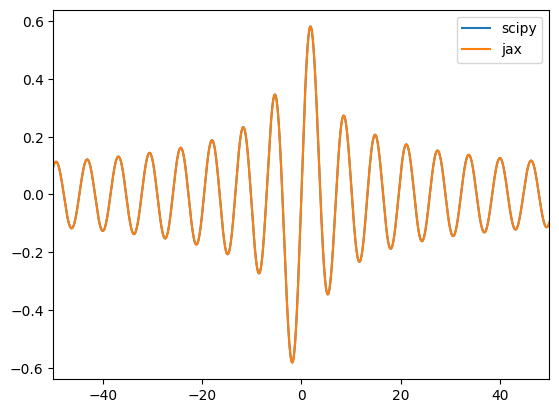

In [178]:
x = np.linspace(-50, 50, 10000)

y = jv(1, x)
yy = j1(x)
# yy_large = j1_large(x)
# yy_small = j1_small(x)
# yy_c = j1_c(x)

plt.plot(x, y, label="scipy")
plt.plot(x, yy, label="jax")
# plt.plot(x, yy_large, label="jax large")
# plt.plot(x, yy_c, label="jax c")

plt.legend()
plt.xlim(-50,50)


(-50.0, 50.0)

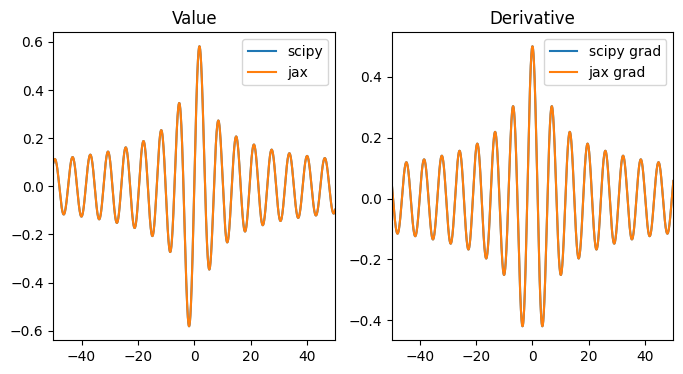

In [179]:
## do the plot of the value and the derivative, in subplots (1,2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4),sharex=True)

ax1.plot(x, y, label="scipy")
ax1.plot(x, yy, label="jax")
ax1.legend()
ax1.set_title('Value')

gscipy = 0.5 * (jv(0, x) - jv(2, x))
ax2.plot(x, gscipy, label="scipy grad")
ax2.plot(x, gg, label="jax grad")
gscipy = 0.5 * (jv(0, x) - jv(2, x))
ax2.legend()
ax2.set_title("Derivative")
ax1.set_xlim(-50, 50)

(-50.0, 50.0)

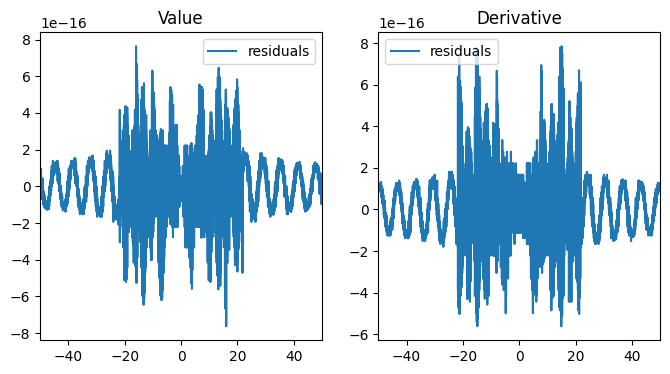

In [180]:
## do the plot of the value and the derivative, in subplots (1,2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4),sharex=True)

ax1.plot(x, y-yy, label="residuals")
ax1.legend()
ax1.set_title('Value')

ax2.plot(x, gg-gscipy, label="residuals")
gscipy = 0.5 * (jv(0, x) - jv(2, x))
ax2.legend()
ax2.set_title("Derivative")
ax1.set_xlim(-50, 50)

In [181]:
(np.all(np.isfinite(gg)),np.all(np.isfinite(yy)))

(True, True)